### Image Captioning 
- Converting Image to a text.
    - Works as visual Aid for blind people.

In [31]:
!pip install tensorflow==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 77.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting

In [32]:
import tensorflow as tf
print(tf.__version__)

2.13.1


In [35]:
import keras
print(keras.__version__)


2.13.1


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

In [37]:
!dir

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


descriptions.txt


In [38]:
# read text captions

def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [39]:
captions = readTextFile('/kaggle/input/flickr8k/captions.txt')

In [40]:
captions = captions.split('\n')[:-1]

In [41]:
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [42]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]
    
    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)


In [43]:
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [44]:
import cv2

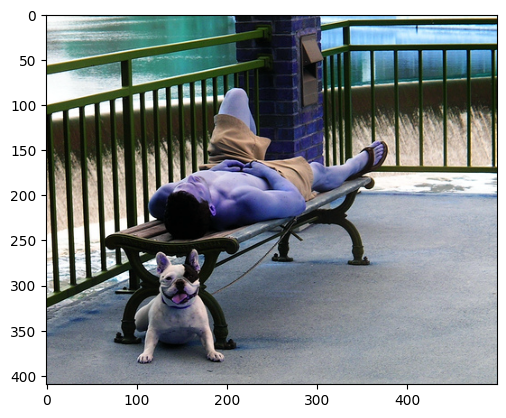

['A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .',
 'a man sleeping on a bench outside with a white and black dog sitting next to him .',
 'A shirtless man lies on a park bench with his dog .',
 'man laying on bench holding leash of dog sitting on ground']

In [45]:
path = '/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1003163366_44323f5815.jpg']

### Data Cleaning
**HERE**
- Do not remove stopwords
- Do not stemming
- Remove numbers, punctuations

$X \rightarrow MODEL \rightarrow \textbf{Dense layer with soft max}\rightarrow vector[\textbf{probability distribution of each word}]$

In [46]:
import re

In [47]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [48]:
# clean all captions

In [49]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [50]:
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [51]:
import os
print(os.listdir('/kaggle/working'))


['.virtual_documents', 'descriptions.txt']


In [52]:
# write the data to text file 
with open('/kaggle/working/descriptions.txt', 'w') as f:
    f.write(str(desc))


### Vocabulary


In [53]:
import json

In [54]:
descriptions = None
with open('/kaggle/working/descriptions.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(json_acceptable_string)

In [56]:
print(type(descriptions))

<class 'dict'>


In [57]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [60]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8258


In [61]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [62]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 357792


In [63]:
len(total_words), type(total_words)

(357792, list)

In [64]:
# filter words from vocab according to certain threshold frequency

In [65]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
# print(frq_cnt)

8258


In [66]:
# sort the dictionary according to the freq count

sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [67]:
#sorted_freq_cnt

In [68]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [69]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

### Train/Val/Test Data

In [70]:
len(descriptions.keys()), len(descriptions.values())

(8092, 8092)

In [71]:
import random 

# Extract keys (image filenames)
image_filenames = list(descriptions.keys())

# # Shuffle and split into train (80%) and test (20%) sets
# random.shuffle(image_filenames)
# split_index = int(0.8 * len(image_filenames))  # 80% for training
# train_filenames = image_filenames[:split_index]
# test_filenames = image_filenames[split_index:]

# # Save train and test filenames to their respective files
# with open('train.txt', 'w') as train_file:
#     for filename in train_filenames:
#         train_file.write(f"{filename}\n")

# with open('test.txt', 'w') as test_file:
#     for filename in test_filenames:
#         test_file.write(f"{filename}\n")

random.shuffle(image_filenames)
split_index_test = int(0.8 * len(image_filenames))  # 80% for train + val
train_val_filenames = image_filenames[:split_index_test]
test_filenames = image_filenames[split_index_test:]

# Split train + val into train (70%) and val (30%)
split_index_val = int(0.7 * len(train_val_filenames))  # 70% for train
train_filenames = train_val_filenames[:split_index_val]
val_filenames = train_val_filenames[split_index_val:]

# Save filenames to their respective files
with open('train.txt', 'w') as train_file:
    for filename in train_filenames:
        train_file.write(f"{filename}\n")

with open('val.txt', 'w') as val_file:
    for filename in val_filenames:
        val_file.write(f"{filename}\n")

with open('test.txt', 'w') as test_file:
    for filename in test_filenames:
        test_file.write(f"{filename}\n")

In [72]:
train_file_data = readTextFile('/kaggle/working/train.txt')
val_file_data = readTextFile('/kaggle/working/val.txt')
test_file_data = readTextFile('/kaggle/working/test.txt')

In [73]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
val = [row.split('.')[0] for row in val_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]

In [74]:
len(train), len(val), len(test)

(4531, 1942, 1619)

In [75]:
print(descriptions.get('1000268201_693b08cb0e.jpg'))

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [76]:
if 'image' in train:
    train.remove('image')

if 'image' in test:
    test.remove('image')

if 'image' in val:
    val.remove('image')
    

In [78]:
id = '1000268201_693b08cb0e'
descriptions[id+'.jpg']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [79]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
    # print("---------------------")
    train_descriptions[img_id] = []
    # print(img_id)
    # print(descriptions[img_id+'.jpg'])
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)



In [80]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
val_descriptions = {}
for img_id in val:
    # print("---------------------")
    val_descriptions[img_id] = []
    # print(img_id)
    # print(descriptions[img_id+'.jpg'])
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        val_descriptions[img_id].append(cap_to_append)


In [81]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
test_descriptions = {}
for img_id in test:
    # print("---------------------")
    test_descriptions[img_id] = []
    # print(img_id)
    # print(descriptions[img_id+'.jpg'])
    for cap in descriptions[img_id+'.jpg']:
        cap_to_append = "startseq " + cap + " endseq"
        test_descriptions[img_id].append(cap_to_append)



## Transfer Learning
- Images -> Features
- Text -> Features
<br>

### Step 1: Image Feature Extraction

In [94]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
model.summary()

102967424/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [95]:
model_new = Model(model.input,model.layers[-2].output)

In [96]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

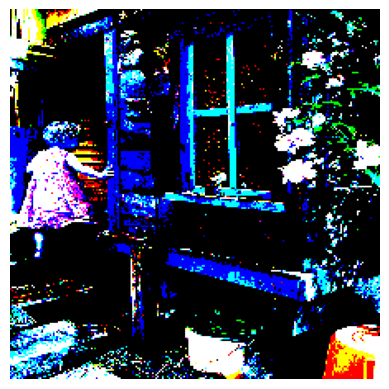

In [97]:
img = preprocess_img('/kaggle/input/flickr8k/Images/'+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [98]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)  
    feature_vector = feature_vector.reshape((2048,))
    #print(feature_vector.shape)
    return feature_vector

In [99]:
encode_image('/kaggle/input/flickr8k/Images/'+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 1s 995ms/step


array([0.0653655 , 0.16782714, 0.32518485, ..., 0.05111531, 0.32817912,
       1.0043339 ], dtype=float32)

In [100]:
type(train)

list

In [133]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(train):
    img_path = '/kaggle/input/flickr8k/Images/'+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 101ms/step
Encoding in progress time step 0 
1/1 [==============================] - 0s 94ms/step
Encoding in progress time step 100 
1/1 [==============================] - 0s 86ms/step
Encoding in progress time step 200 
1/1 [==============================] - 0s 83ms/step
Encoding in progress time step 300 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 400 
1/1 [==============================] - 0s 86ms/step
Encoding in progress time step 500 
1/1 [==============================] - 0s 98ms/step
Encoding in progress time step 600 
1/1 [==============================] - 0s 85ms/step
Encoding in progress time step 700 
1/1 [==============================] - 0s 87ms/step
Encoding in progress time step 800 
1/1 [==============================] - 0s 86ms/step
Encoding in progress time step 900 
1/1 [==============================] - 0s 89ms/step
Encoding in progress time step 1000 
1/1 [===========================

In [134]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(test):
    img_path = '/kaggle/input/flickr8k/Images'+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 92ms/step
Encoding in progress time step 0 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 100 
1/1 [==============================] - 0s 86ms/step
Encoding in progress time step 200 
1/1 [==============================] - 0s 95ms/step
Encoding in progress time step 300 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 400 
1/1 [==============================] - 0s 88ms/step
Encoding in progress time step 500 
1/1 [==============================] - 0s 87ms/step
Encoding in progress time step 600 
1/1 [==============================] - 0s 92ms/step
Encoding in progress time step 700 
1/1 [==============================] - 0s 93ms/step
Encoding in progress time step 800 
1/1 [==============================] - 0s 116ms/step
Encoding in progress time step 900 
1/1 [==============================] - 0s 89ms/step
Encoding in progress time step 1000 
1/1 [===========================

In [135]:
start = time()
encoding_val = {}
#image_id -->feature_vector extracted from Resnet Image
for ix,img_id in enumerate(val):
    img_path = '/kaggle/input/flickr8k/Images/'+"/"+img_id+".jpg"
    encoding_val[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Encoding in progress time step %d "%ix)
end_t = time()
print("Total Time Taken :",end_t-start)

1/1 [==============================] - 0s 89ms/step
Encoding in progress time step 0 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 100 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 200 
1/1 [==============================] - 0s 87ms/step
Encoding in progress time step 300 
1/1 [==============================] - 0s 93ms/step
Encoding in progress time step 400 
1/1 [==============================] - 0s 88ms/step
Encoding in progress time step 500 
1/1 [==============================] - 0s 84ms/step
Encoding in progress time step 600 
1/1 [==============================] - 0s 93ms/step
Encoding in progress time step 700 
1/1 [==============================] - 0s 90ms/step
Encoding in progress time step 800 
1/1 [==============================] - 0s 87ms/step
Encoding in progress time step 900 
1/1 [==============================] - 0s 89ms/step
Encoding in progress time step 1000 
1/1 [============================

In [137]:
# # Store everything to the disk 
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_val_features.pkl","wb") as f:
    pickle.dump(encoding_val ,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [139]:
len(total_words)

1800

In [140]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [141]:
word_to_idx['dog']
idx_to_word[1]

'in'

In [142]:
len(idx_to_word)

1800

In [143]:
idx_to_word[1801] = 'startseq'
word_to_idx['startseq'] = 1801

idx_to_word[1802] = 'endseq'
word_to_idx['endseq'] = 1802

In [144]:
vocab_size =len(word_to_idx)+1
print(vocab_size)

1803


In [145]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

31


### Data Loader

In [146]:
from keras.utils import to_categorical

In [147]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = tf.keras.utils.to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [148]:
f = open("/kaggle/input/glove6b/glove.6B.50d.txt",encoding='utf8')

In [149]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [150]:
embedding_index['apple'] # embedding for apple

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [151]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [152]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1803, 50)

# Model

In [153]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [154]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [155]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [156]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 31, 50)               90150     ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']             
                                                                                            

In [157]:
# Embedding Layer most important
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

- categorical_crossentropy is used with large no. of classes

In [158]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'] )


In [159]:
# model training 
epochs = 30
batch_size = 32
steps = len(train_descriptions)//batch_size + 1


In [160]:
print(keras.__version__)
print(tf.__version__)

2.13.1
2.13.1


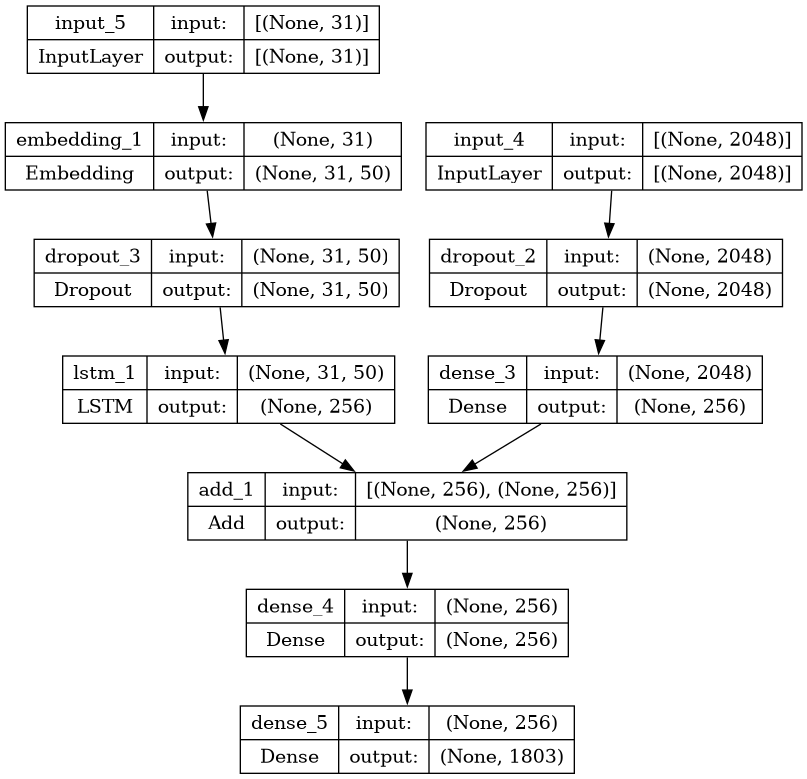

In [161]:
import pydot
import graphviz
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

Considering batch size to be 3 ,
at each step we would be training our for 1 batch , means 3 images with there respective captions . So , the number of pics per batch will be equal to batch_Size.
hence, number of pics per batch is 3.

and steps = 1000 //3 = 33 ( assuming your len( train_descriptions ) = 1000 )

In [162]:
encoding_train['1032122270_ea6f0beedb']

array([2.119439  , 0.48909783, 0.19077976, ..., 1.1809856 , 0.10302494,
       0.30981818], dtype=float32)

In [163]:
from keras.metrics import CategoricalAccuracy
from nltk.translate.bleu_score import sentence_bleu

# Track metrics
train_loss = []
val_loss = []
train_accuracy = CategoricalAccuracy()
val_accuracy = CategoricalAccuracy()

# BLEU Score Calculation
def calculate_bleu(reference, prediction):
    reference = [ref.split() for ref in reference]
    prediction = prediction.split()
    bleu1 = sentence_bleu(reference, prediction, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu(reference, prediction, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu(reference, prediction, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu(reference, prediction, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu1, bleu2, bleu3, bleu4


In [164]:
import wandb
from wandb.integration.keras import WandbCallback

# Đăng nhập WandB
wandb.login(key="88aea2f639fada32b4501731dc07e972dc732128")  # Thay "your_api_key_here" bằng API Key của bạn

# Khởi tạo dự án trên WandB
wandb.init(
    project="image-captioning",  # Tên dự án của bạn
    # name="captioning-model-run",  # Tên phiên bản (run)
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": "adam",
        "loss": "categorical_crossentropy"
    }
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [165]:
# def train():
    
#     for i in range(epochs):
#         generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
#         model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
#         model.save('./model_weights/model_'+str(i)+'.h5')

In [166]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, photo, word_to_idx, idx_to_word, max_len):
    """
    Generate a caption for a given image using the trained model.
    
    :param model: Trained model
    :param photo: Feature vector of the image
    :param word_to_idx: Mapping of words to their indices
    :param idx_to_word: Mapping of indices to their corresponding words
    :param max_len: Maximum length of the caption
    :return: Generated caption
    """
    in_text = "startseq"
    for _ in range(max_len):
        # Convert the caption into a sequence of indices
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        # Predict the next word
        yhat = model.predict([photo.reshape(1, 2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        # Map the predicted index to the word
        word = idx_to_word.get(yhat)
        if word is None:
            break
        in_text += " " + word
        
        # Stop if "endseq" is predicted
        if word == "endseq":
            break
    return in_text


In [167]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_scores(descriptions, encoding):
    bleu1, bleu2, bleu3, bleu4 = 0, 0, 0, 0
    total_samples = len(descriptions)

    for img_id, refs in descriptions.items():
        references = [ref.split() for ref in refs]
        predicted_caption = generate_caption(model, encoding[img_id], word_to_idx, idx_to_word, max_len).split()
        bleu1 += sentence_bleu(references, predicted_caption, weights=(1, 0, 0, 0))
        bleu2 += sentence_bleu(references, predicted_caption, weights=(0.5, 0.5, 0, 0))
        bleu3 += sentence_bleu(references, predicted_caption, weights=(0.33, 0.33, 0.33, 0))
        bleu4 += sentence_bleu(references, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu1 / total_samples, bleu2 / total_samples, bleu3 / total_samples, bleu4 / total_samples


In [168]:
def train():
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training
        train_generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        train_steps = len(train_descriptions) // batch_size
        history = model.fit(
            train_generator,
            epochs=1,
            steps_per_epoch=train_steps,
            verbose=1
        )
        train_loss = history.history['loss'][-1]
        train_acc = history.history.get('accuracy', [0])[-1]

        # Validation
        val_generator = data_generator(val_descriptions, encoding_val, word_to_idx, max_len, batch_size)
        val_steps = len(val_descriptions) // batch_size
        val_loss, val_acc = model.evaluate(
            val_generator,
            steps=val_steps,
            verbose=1
        )

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        })

        # Log metrics
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss}, Train Accuracy: {train_acc}")
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

        # Save model weights
        model.save(f'./model_weights/model_epoch_{epoch+1}.h5')

In [169]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical

In [170]:
#uncomment to train
train()

Epoch 1/30
60/60 [==============================] - 23s 367ms/step - loss: 4.4012 - accuracy: 0.2115
Epoch 1: Train Loss: 5.037796497344971, Train Accuracy: 0.15746955573558807
Validation Loss: 4.401226043701172, Validation Accuracy: 0.21150797605514526
Epoch 2/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 22s 368ms/step - loss: 3.9485 - accuracy: 0.2494
Epoch 2: Train Loss: 4.144382953643799, Train Accuracy: 0.22358638048171997
Validation Loss: 3.948460340499878, Validation Accuracy: 0.24938341975212097
Epoch 3/30
60/60 [==============================] - 21s 355ms/step - loss: 3.7758 - accuracy: 0.2612
Epoch 3: Train Loss: 3.7791357040405273, Train Accuracy: 0.2526266872882843
Validation Loss: 3.7757925987243652, Validation Accuracy: 0.26118648052215576
Epoch 4/30
60/60 [==============================] - 21s 357ms/step - loss: 3.6822 - accuracy: 0.2726
Epoch 4: Train Loss: 3.5575599670410156, Train Accuracy: 0.2702161967754364
Validation Loss: 3.6821775436401367, Validation Accuracy: 0.2725711166858673
Epoch 5/30
60/60 [==============================] - 21s 352ms/step - loss: 3.6293 - accuracy: 0.2781
Epoch 5: Train Loss: 3.399097204208374, Train Accuracy: 0.2845696210861206
Validation Loss: 3.629326820373535, Validation Accuracy: 0.2780982851982

In [172]:
test_generator = data_generator(test_descriptions, encoding_test, word_to_idx, max_len, batch_size)
test_steps = len(test_descriptions) // batch_size
test_loss, test_acc = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)
test_bleu1, test_bleu2, test_bleu3, test_bleu4 = calculate_bleu_scores(test_descriptions, encoding_test)

# Log test metrics to WandB
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "test_bleu1": test_bleu1,
    "test_bleu2": test_bleu2,
    "test_bleu3": test_bleu3,
    "test_bleu4": test_bleu4,
})

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
print(f"Test BLEU: BLEU-1: {test_bleu1}, BLEU-2: {test_bleu2}, BLEU-3: {test_bleu3}, BLEU-4: {test_bleu4}")

50/50 [==============================] - 18s 351ms/step - loss: 3.8974 - accuracy: 0.2997


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Test Loss: 3.897372007369995, Test Accuracy: 0.2997194528579712
Test BLEU: BLEU-1: 0.5492683297312241, BLEU-2: 0.4380855733373547, BLEU-3: 0.46442104188303224, BLEU-4: 0.5205709574168196


In [ ]:
# # Calculate BLEU score on test set
#     bleu_scores = {"bleu1": 0, "bleu2": 0, "bleu3": 0, "bleu4": 0}
#     total_samples = 0
#     for img_id in test:
#         total_samples += 1
#         references = descriptions[img_id + '.jpg']
#         predicted_caption = generate_caption(model, encoding_test[img_id], word_to_idx, idx_to_word, max_len)
#         bleu1, bleu2, bleu3, bleu4 = calculate_bleu(references, predicted_caption)
#         bleu_scores["bleu1"] += bleu1
#         bleu_scores["bleu2"] += bleu2
#         bleu_scores["bleu3"] += bleu3
#         bleu_scores["bleu4"] += bleu4

#     # Average BLEU scores
#     for key in bleu_scores.keys():
#         bleu_scores[key] /= total_samples

#     print("Test BLEU Scores:", bleu_scores)

#     # Log BLEU score
#     wandb.log(bleu_scores)

In [6]:
# from keras.models import load_model
# from keras.initializers import Orthogonal

# # Define custom objects to resolve the initializer issue
# custom_objects = {
#     'Orthogonal': Orthogonal
# }


In [7]:
# from tensorflow.keras.optimizers import Adam

In [9]:
# model = load_model('/kaggle/input/model_weights/pytorch/default/1/model_9.h5', compile=False)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

In [ ]:
# model = load_model('/kaggle/input/model_weights/pytorch/default/1/model_9.h5', custom_objects=custom_objects)

## FINAL PREDICTIONS

In [184]:
# def predict_caption(photo):
    
#     in_text = "startseq"
#     for i in range(max_len):
#         sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
#         sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
#         final_caption = set()
#         ypred = model.predict([photo,sequence])
#         ypred = ypred.argmax() 
#         print("ypred: ", ypred)
#         word = idx_to_word[ypred]
#         in_text = ' ' + word
#         final_caption.add(in_text)
        
#         print(in_text)
        
#         if word == "endseq":
#             break
    
# #         final_caption = in_text.split()[1:-1]
#         st = ' '.join(final_caption)
#         final_caption.clear()
    
#     return st

def predict_caption(photo):
    # Initialize the caption with the starting token
    in_text = "startseq"
    for i in range(max_len):
        # Convert the current caption to a sequence of indices
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        
        # Pad the sequence to match the model's input shape
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        # Predict the next word
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()  # Get the index of the word with the highest probability
        
        # Map the predicted index back to a word
        word = idx_to_word[ypred]
        
        # Break if the end token is generated
        if word == "endseq":
            break
        
        # Append the predicted word to the current caption
        in_text += ' ' + word
        
    # Remove start and end tokens and return the final caption
    final_caption = in_text.split()[1:]  # Exclude the start token
    return ' '.join(final_caption)


In [181]:
print("Max length used in training:", max_len)


Max length used in training: 31


In [182]:
desc['1003163366_44323f5815.jpg']

['man lays on bench while his dog sits by him',
 'man lays on the bench to which white dog is also tied',
 'man sleeping on bench outside with white and black dog sitting next to him',
 'shirtless man lies on park bench with his dog',
 'man laying on bench holding leash of dog sitting on ground']

1/1 [==============================] - 0s 26ms/step


/tmp/ipykernel_23/1014049350.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


1/1 [==============================] - 0s 25ms/step


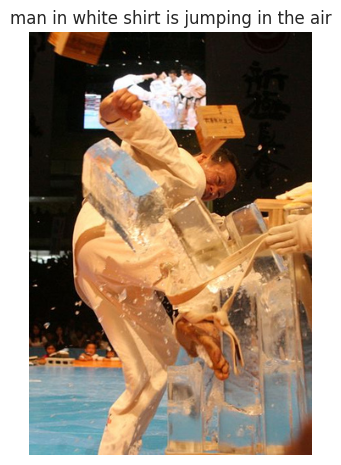

1/1 [==============================] - 0s 23ms/step


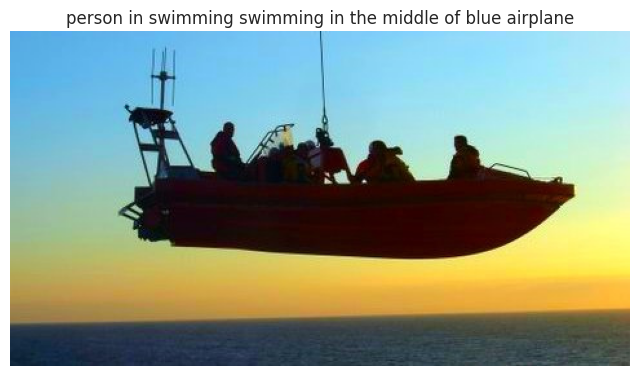

1/1 [==============================] - 0s 25ms/step


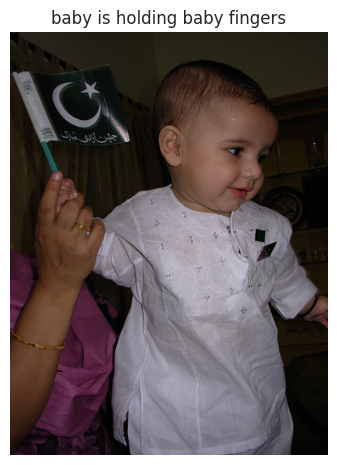

1/1 [==============================] - 0s 22ms/step


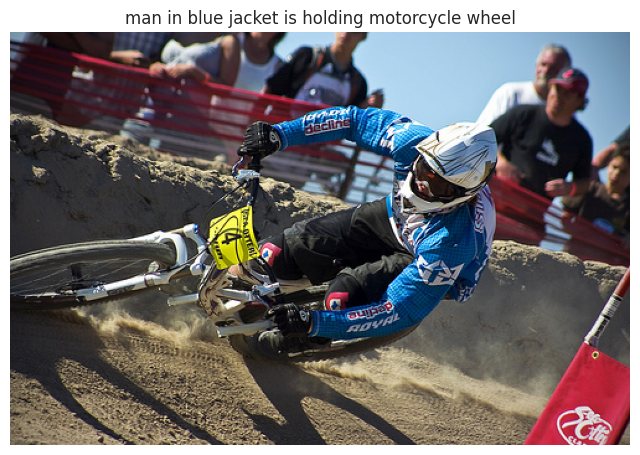

1/1 [==============================] - 0s 22ms/step


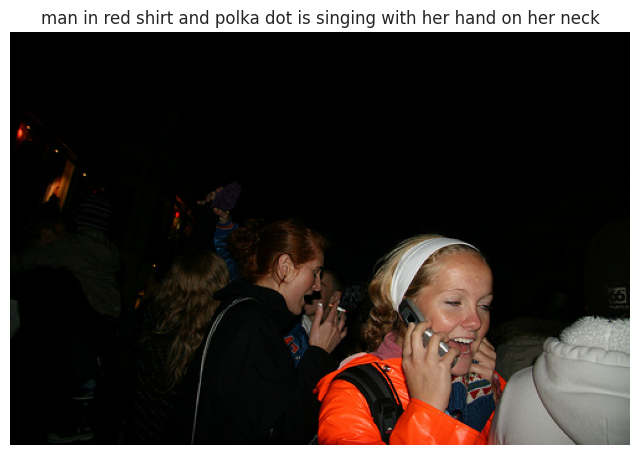

1/1 [==============================] - 0s 21ms/step


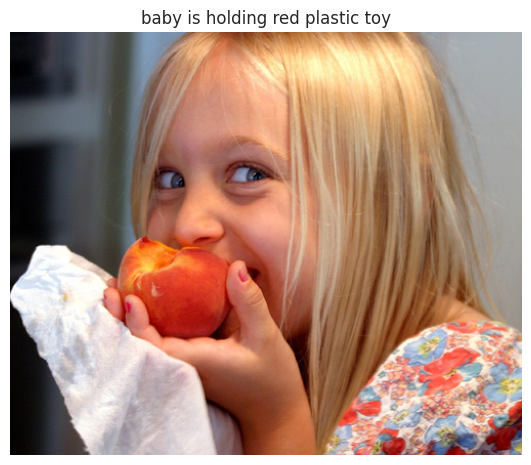

1/1 [==============================] - 0s 23ms/step


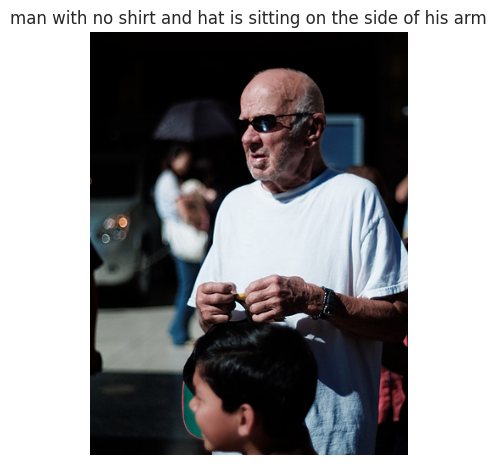

1/1 [==============================] - 0s 22ms/step


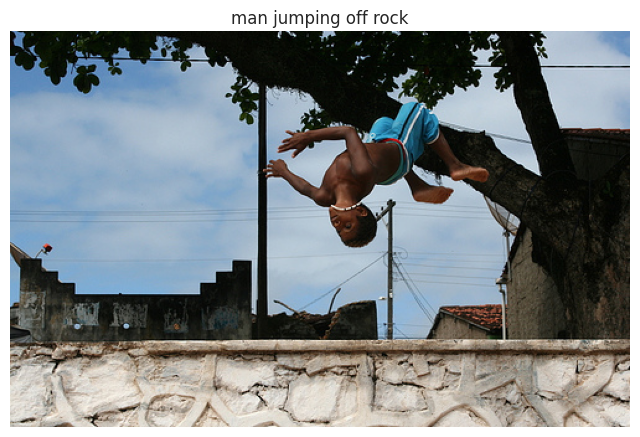

1/1 [==============================] - 0s 22ms/step


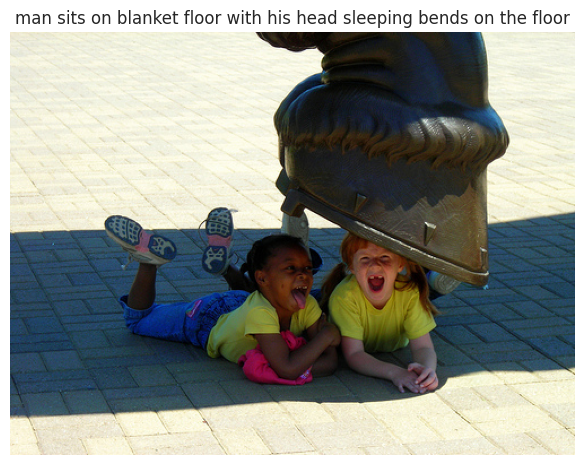

1/1 [==============================] - 0s 23ms/step


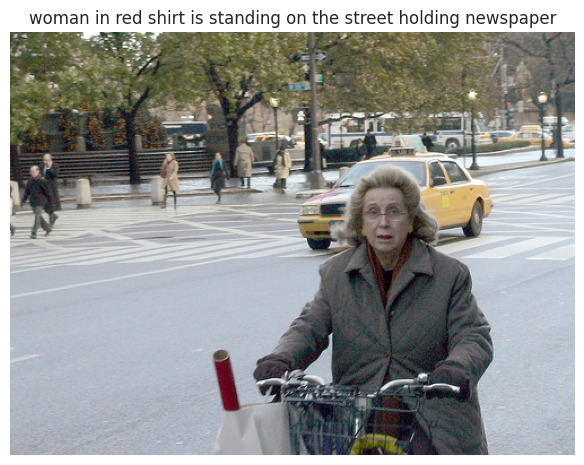

In [188]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(10):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/kaggle/input/flickr8k/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)

    image = plt.imread(f"/kaggle/input/flickr8k/Images/{img_name}.jpg")
    # Log to wandb
    wandb.log({
        "Generated Captions": wandb.Image(image, caption=caption)}
    )
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [179]:
len(encoding_test)

1619